In [1]:
##편향되지 않는 모델 성능 측정하기
##머신 러닝 알고리즘에서 일반적으로 발생하는 문제 분석하기
##머신 러닝 모델 세부 튜닝하기
##여러 가지 성능 지표를 사용하여 모델의 예측 성능 평가하기

In [2]:
####파이프라인을 사용한 워크 플로####
##여러개의 변환 단계를 포함한 모델을 학습하고 새로운 데이터에 대한 예측 생성 가능

In [3]:
##훈련 세트와 테스트 세트로 분할하기

#유방암 데이터 불러오기
import pandas as pd

df = pd.read_csv(r'E:\Programming\python\ML\data\wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
#30개의 특성을 넘파이 배열 X에 할당. LabelEncoder 객체를 사용하여 원본 문자열에서 정수로 변환
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [5]:
#악성(Benign)은 클래스 1로 표현, 양성(Malignant)는 클래스 0으로 표현된다
le.transform(['M','B'])

array([1, 0], dtype=int64)

In [6]:
#훈련세트 80%, 테스트 세트 20%로 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [7]:
##PCA를 통해 30차원의 데이터를 2차원으로 낮추기
#StandardScaler, PCA, LogisticRegression을 하나의 파이프라인으로 연결
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear', random_state=1))
pipe_lr.fit(X_train, y_train) #pipline에 묶여있는 모든 변환기의 fit과 transform 메서드를 차례로 거쳐 추정기 객체에 도달한다.
y_pred = pipe_lr.predict(X_test) #predict 메서드는 마지막 추정기 객체가 변환된 데이터의 예측을 반환한다.
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


In [8]:
##사이킷런 변환기 중 fit/transform 메서드를 지원하는 객체에 한에서 make_pipline 함수를 이용해 연결 가능하다.
#위의 pipline 예시를 분석해보면 우선적으로 StandardScaler의 fit과 transform 메서드를 거쳐 변환된 데이터를 PCA 객체로 전달되 저차원으로 변환한 후 LogisticRegression 모델이 변환된 데이터로 학습한다. 중간단계의 개수 제한은 없지만 중요한 점은 마지막 단계는 항상 추정기가 되어야한다는 점이다.

In [9]:
####홀드아웃 교차 검증####
#1. 초기 데이터셋을 별도의 훈련세트(모델 훈련용)와 테스트 세트(일반화 성능 추정용)로 나눈다
##모델선택(예측 성능을 높이기 위해 하이퍼파라미터를 튜닝하고 비교하는 과정 중 최적의 파라미터를 선택한는 것)에서 테스트 세트를 계속 사용하면 과대 적합이 된다.
#2. 홀드 아웃에선 훈련세트를 다시 훈련세트(여러가지 모델 훈련), 검증 세트(최적의 파라미터가 나올때까지 반복적으로 모델 성능 평가), 그 후 기존에 사용하지 않은(모델 입장에선 처음 마주한) 테스트 세트를 통해 성능평가 실시
#단점: 훈련 데이터를 어떤 방법으로 검증과 훈련 데이터 세트로 나누느냐에 따라 성능 추정이 민감할 수 있음

In [10]:
####k-겹 교차 검증####
#중복을 허락하지 X => 검증에 한 번만 사용되는 장점
#1. 훈련 데이터셋을 k개의 폴드로 랜덤하게 나눔
#2. k-1개의 폴드로 모델을 훈련하고 남은 한 개로 모델을 평가
#3. 이 과정을 k번 반복하여 k개의 모델과 성능 추정을 얻는다
#4. 독립적인 모델들의 평균 성능을 계산
##주로 최적의 파라미터를 찾기 위해 사용
#5. 최적의 파라미터를 찾은 후엔 전체 훈련 세트를 사용하여 모델을 다시 훈련한다(전체 훈련 세트를 사용하는 이유는 훈련 세트가 클수록 알고리즘이 더 정확하고 안정적이기 때문)
#6. 독립적인 테스트 세트를 사용해서 최종 성능을 추정한다


In [11]:
####계층적 k-겹 교차 검증####
##클래스 비율이 동등하지 않을때 좀 더 나은 편향과 분산 추정을 만든다

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, #훈련세트의 y_train 클래스 레이블을 전달해서 초기화 / n_splits로 폴드 개수 지정
                        random_state=1).split(X_train, y_train) 
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1, np.bincount(y_train[train]), score))
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956

CV 정확도: 0.950 +/- 0.014


In [13]:
#계층별 k-겹 교차 검증 사용
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1) #하나의 cpu코어만 성능평가에 참여 (2로 설정하면 두개의 코어에 교차검증을 10회씩 분산/-1은 설치된 모든 코어에 병렬처리)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


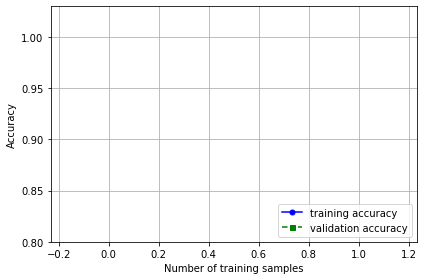

In [14]:
##학습 곡선 함수를 통한 모델 평가##
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='liblinear',
                                           penalty='12',
                                           random_state=1))
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10), #일정한 간격으로 훈련세트 비율 열개를 검증
                               cv=10, #k겹 교차의 k 값이 10을 뜻함
                               n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')

plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

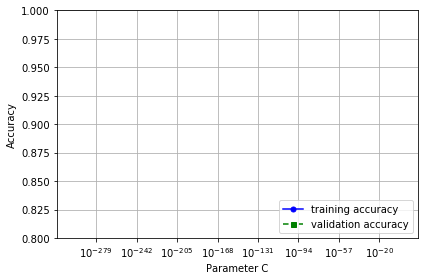

In [15]:
###검증 곡선으로 과대적합과 과소적합 조사###
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green',linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

In [16]:
####왜 안나올까....####

In [17]:
##그리드 서치##
#리스트로 지정된 여러 하이퍼파라미터 값 전체를 조사
#리스트의 모든 조합에 대해 최적의 조합 찾기

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_) #svc__C가 100인 rbf 커널이 가장 좋은 정확도 달성

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [19]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


In [20]:
##중첩 교차 검증##
#이 방법 사용시 테스트 세트에 대한 추정 오차는 거의 편향 되지 않음

In [21]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.974 +/- 0.015


In [22]:
##중첩 교차 검증을 사용하여 SVM 모델과 단일 결정 트리 분류기 비교하기
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.934 +/- 0.016


In [23]:
#결정트리는 정확도가 0.934로 SVM보다 낮은 것을 알 수 있다.

In [24]:
##정밀도, 재현율, F1-점수 도 모델이 적합한지 측정하는 지표들이다.

In [25]:
##오차 행렬##
#사진#

In [26]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


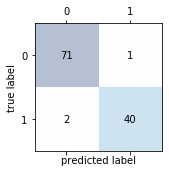

In [27]:
##그림으로 나타내기
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

In [28]:
#40개의 샘플은 클래스1(True Positive)로 올바르게 분류, 71개의 샘플도 클래스0(True Negative)으로 올바르게 분류.
#클래스1에 들어가야 할 샘플 2개를 클래스 0으로 잘못 분류(False Negative), 양성 종양 하나를 악성 종양으로 잘못 분류

In [29]:
##오차 지표 계산하기##
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))

print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정밀도: 0.976
재현율: 0.952
F1: 0.964


In [30]:
#GridSearchCV의 scoring 매개변수를 이요하여 정확도 대신 다른 성능 지표 사용 가능

In [31]:
#사이킷런에서 양성 클래스는 레이블이 1인 클래스
#양성 레이블을 바꾸고 싶다면 make_scorer 함수를 사용하여 자신만의 함수 생성 가능
#f1_score을 지표로 사용하는 경우
from sklearn.metrics import make_scorer, f1_score

scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [32]:
##ROC(Receiver Operating Characteristic) 곡선 그리기##
#임계값을 바꾸어 계산된 FPR과 TPR 점수를 기반으로 분류 모델을 선택할 수 있는 유용한 도구
#대각선 기준으로 아래의 모델은 랜덤 추측보다 안좋은 모델
#완벽한 분류기는 TPR이 1이고 FPR이 0인 왼쪽 위 구석
#ROC곡선 아래의 면적인 ROC AUC(ROC Area Under the Curve)를 계산해서 모델의 성능을 종합 할 수 있다

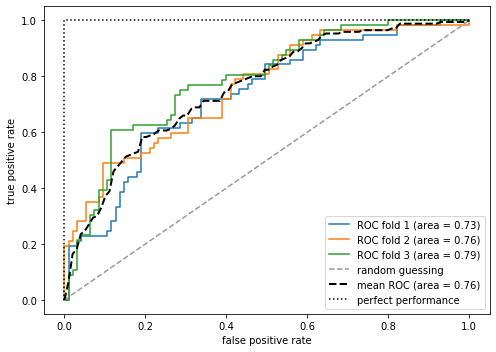

In [33]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear',
                                           penalty='l2',
                                           random_state=1,
                                           C=100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1], pos_label=1) #Logistic Regression의 ROC 값 계산
    mean_tpr += interp(mean_fpr, fpr, tpr) #세 개의 폴드에 대한 ROC 곡선을 보간하여 평균 구하기
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr) #곡선 아래 면적 계산
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [34]:
##다중 분류의 성능 지표##
#마크로(macro)와 마이크로(micro) 평균 방식을 구현하여 OvA(One-versus-All)방식을 사용하는 다중 분류
#마이크로는 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때 사용
#마크로는 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능 평가
#가중치가 적용된 마크로 평균은 레이블마다 샘플 개수가 다른 불균형한 클래스 다룰 때 유용

In [35]:
####불균형한 클래스 다루기####
#212개의 악성 종양(클래스 1)과 357개의 양성 종양(클래스 0)을 가진 유방암 데이터셋에서 불균형한 데이터셋 만들기
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

In [36]:
#무조건 다수 클래스를 예측하는 모델은 거의 90%의 정확도를 달성
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [37]:
#위와 같은 데이터셋에선 정확도를 모델 성능 비교의 지표로 쓰기 보다는 다른 지표를 활용하는 것이 나음
#불균형한 클래스를 다루는 방법
#1. 소수 클래스에서 발생한 예측 오류에 큰 벌칙을 부여
#2. 소수 클래스의 샘플을 늘리기
#3. 다숭 클래스의 샘플을 줄이기
#4. 인공적인 훈련 샘플을 생성

In [38]:
#소수의 샘플 늘리기
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_unsampled, y_unsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)
print('샘플링한 후 클래스 1의 샘플 개수:', X_unsampled.shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 40
샘플링한 후 클래스 1의 샘플 개수: 357


In [39]:
#클래스 0인 원본 샘플과 업샘플링된 클래스 1을 연결하여 균형 잡힌 데이터셋 얻기
X_bal = np.vstack((X[y==0], X_unsampled))
y_bal = np.hstack((y[y==0], y_unsampled))

In [40]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

In [42]:
#다수 클래스를 예측하는 규칙은 50%의 정확도를 달성

In [44]:
#다운샘플링은 클래스 레이블 1과 0을 바꾸면된다